In [74]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader
import pdb

cudnn.benchmark = True
plt.ion()


In [75]:
## data augmentation and normalisation
import medmnist

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

chestTrain = medmnist.ChestMNIST(split="train",transform=transform,download=True,size=224)
retinaTrain = medmnist.RetinaMNIST(split="train",transform=transform,download=True, size=224)
dermaTrain = medmnist.DermaMNIST(split="train",transform=transform,download=True,size=224)
breastTrain = medmnist.BreastMNIST(split="train",transform=transform,download=True,size=224)

chestVal = medmnist.ChestMNIST(split="val",transform=transform,download=True,size=224)
retinaVal = medmnist.RetinaMNIST(split="val",transform=transform,download=True,size=224)
dermaVal = medmnist.DermaMNIST(split="val",transform=transform,download=True,size=224)
breastVal = medmnist.BreastMNIST(split="val",transform=transform,download=True,size=224)

chestTest = medmnist.ChestMNIST(split="test",transform=transform,download=True,size=224)
retinaTest = medmnist.RetinaMNIST(split="test",transform=transform,download=True,size=224)
dermaTest = medmnist.DermaMNIST(split="test",transform=transform,download=True,size=224)
breastTest = medmnist.BreastMNIST(split="test",transform=transform,download=True,size=224)


In [76]:
datasets = {
    'train':breastTrain,
    'val':breastVal,
    'test':breastTest
}

dataloaders = {
    x:DataLoader(dataset=datasets[x], batch_size=32, shuffle=True)
    for x in ['train','val']
}

dataset_sizes = {
    x: len(datasets[x])
    for x in ['train','val']
}

class_names = datasets['train'].info['label']


In [102]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

def train(model, criterion, optimiser, scheduler, epochs=20):
    since = time.time()

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(),best_model_params_path)
        best_acc = 0

        for epoch in range(epochs):
            print(f"{epoch+1}/{epochs}\n{'-'*10}")

            for phase in ['train','val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()
                
                running_loss=0.0
                running_corrects=0

                # get a batch
                for inputs, labels in dataloaders[phase]:
                    labels = labels.view(-1).long()
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimiser.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _,preds = torch.max(outputs,1)
                        
                        loss = criterion(outputs,labels)

                        if phase=="train":
                            loss.backward()
                            optimiser.step()

                    running_loss+=loss.item()*inputs.size(0)
                    running_corrects += torch.sum(preds==labels.data)
                
                if phase=='train':
                    scheduler.step()
                
                epoch_loss = running_loss/dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f"{phase} loss: {epoch_loss} Acc: {epoch_acc}")

                if phase == 'val' and epoch_acc>best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(),best_model_params_path)

            print()
        
        time_elapsed = time.time()-since
        print(f"training complete in {time_elapsed//60}m {time_elapsed %60}s")
        print(f"best val acc {best_acc}")

        model.load_state_dict(torch.load(best_model_params_path,weights_only=True))
    return model


Text(0.5, 1.0, 'normal, benign')

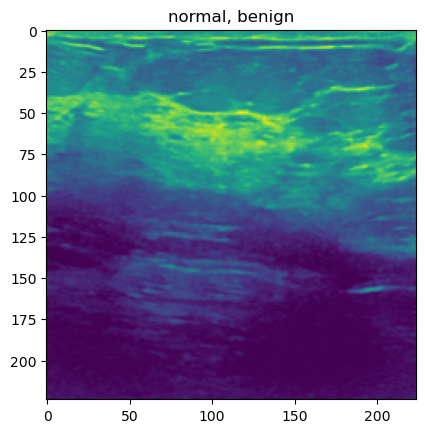

In [79]:
inputs, classes = next(iter(dataloaders['train']))
idx = 26
plt.imshow(inputs[idx].numpy().transpose((1,2,0)))
plt.title(class_names[str(int(classes[idx]))])

In [107]:
def visualise_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _,preds = torch.max(outputs,1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"predicted: {class_names[str(int(preds[j]))]}")

                plt.imshow(inputs.cpu().data[j].numpy().transpose((1,2,0)))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [91]:
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs,2)
old_conv = model.features[0]

model.features[0] = nn.Conv2d(
    in_channels=1,
    out_channels=old_conv.out_channels,
    kernel_size = old_conv.kernel_size,
    stride = old_conv.stride,
    padding = old_conv.padding
)

with torch.no_grad():
    model.features[0].weight = nn.Parameter(old_conv.weight.sum(dim=1, keepdim=True))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimiser,step_size=7, gamma=0.1)

model

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [103]:
model = train(model,criterion,optimiser,exp_lr_scheduler,epochs=5)

1/5
----------
train loss: 0.5401307014755277 Acc: 0.7307692307692307
val loss: 0.6005595800204154 Acc: 0.6410256410256411

2/5
----------
train loss: 0.5091728875925253 Acc: 0.7728937728937729
val loss: 0.489939075249892 Acc: 0.7692307692307693

3/5
----------
train loss: 0.42240172231590356 Acc: 0.8076923076923077
val loss: 0.3474202010876093 Acc: 0.8717948717948718

4/5
----------
train loss: 0.43030305331634294 Acc: 0.8058608058608059
val loss: 0.4857254043603555 Acc: 0.7564102564102564

5/5
----------
train loss: 0.41282062308910566 Acc: 0.8040293040293041
val loss: 0.3074234525362651 Acc: 0.9102564102564102

training complete in 1.0m 17.411658763885498s
best val acc 0.9102564102564102


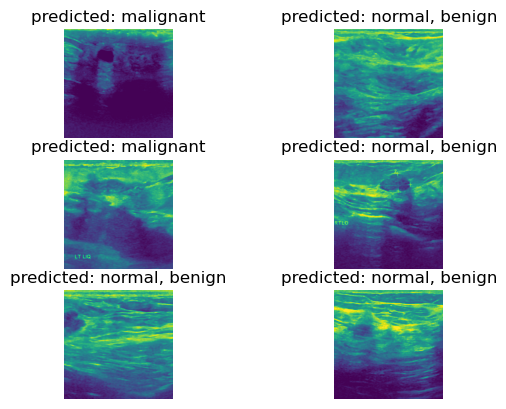

In [108]:
visualise_model(model)